# Feature engineering. CASE: Loans Grade

Loan grading is a classification system that involves assigning a quality score to a loan based on a borrower's credit history, quality of the collateral, and the likelihood of repayment of the principal and interest.
 
 We will prepare the data for the loans grade prediction

In [3]:
#pip install imbalanced-learn

In [3]:
#pip install imblearn

In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
import math

from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.dates import YearLocator, DateFormatter

import scipy.stats.distributions as dist
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

from dask import dataframe as dd
import time

from generic_functions import check_duplicates, check_missing_values, value_counts_to_dataframe, pivot_dim2

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from generic_functions import value_counts_to_dataframe, pivot_dim2
# from modelling_functions import fit_model, kfold_cross_validation
from pca_functions import plot_variance, make_mi_scores

# balancing dataset
from imblearn.over_sampling import SMOTE

from sklearn import model_selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold

from sklearn import metrics
# from sklearn.metrics import roc_curve, auc
from sklearn.metrics import auc
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc_curve
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_recall_curve


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline

from scipy.stats import reciprocal, uniform

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3'

In [35]:
import glob
os.chdir('/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/input')

In [36]:
files_ = [f for f in glob.glob("*.csv")]
files_

['lending_data_2018.csv',
 'lending_data_2009.csv',
 'lending_data_2008.csv',
 'lending_data_2011.csv',
 'lending_data_2010.csv',
 'lending_data_2012.csv',
 'lending_data_2007.csv',
 'lending_data_2013.csv',
 'lending_data_2017.csv',
 'lending_data_2016.csv',
 'lending_data_2014.csv',
 'lending_data_2015.csv']

In [37]:
years_ = ['2016']

In [38]:
matching = []
lst = []
j = 1
for i in years_:
    matching_stg = [s for s in files_ if i in s][0]
    matching.append(matching_stg)
    
for url in matching:  
    path_ = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/input/{url}'
    data = pd.read_csv(path_)
    lst.append(data)                        
df_ = pd.concat(lst)

df_.info()
print(df_.year.unique())
df_ = df_.drop(columns = ['index','level_0','id'])
df_.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434407 entries, 0 to 434406
Columns: 154 entries, level_0 to year
dtypes: float64(114), int64(4), object(36)
memory usage: 510.4+ MB
[2016]


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,year
0,NaN,10000.0,10000.0,10000.0,60 months,13.49,230.05,C,C2,Customer Service,3 years,RENT,32000.0,Not Verified,Jun-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,447xx,OH,13.05,0.0,Apr-1999,750.0,754.0,1.0,NaN,NaN,5.0,0.0,16525.0,47.3,10.0,w,0.00,0.00,10356.270252,10356.27,10000.00,356.27,0.0,0.0,0.0,Oct-2017,454.31,NaN,Oct-2017,769.0,765.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,112399.0,0.0,0.0,0.0,0.0,67.0,0.0,NaN,0.0,0.0,9296.0,47.0,34900.0,1.0,0.0,1.0,0.0,22480.0,18375.0,47.3,0.0,0.0,94.0,206.0,84.0,67.0,1.0,84.0,NaN,6.0,NaN,0.0,2.0,2.0,4.0,7.0,2.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,141464.0,16525.0,34900.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2016
1,NaN,12000.0,12000.0,12000.0,36 months,15.59,419.46,C,C5,Executive Assistant,7 years,MORTGAGE,70000.0,Verified,Jun-2016,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,774xx,TX,22.86,0.0,Aug-2000,695.0,699.0,1.0,NaN,NaN,18.0,0.0,20075.0,56.7,45.0,f,2406.15,2406.15,12479.870000,12479.87,9593.85,2886.02,0.0,0.0,0.0,Dec-2018,419.46,Apr-2019,Mar-2019,619.0,615.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,156605.0,2.0,3.0,1.0,1.0,4.0,31445.0,74.0,1.0,5.0,6031.0,66.0,35400.0,0.0,2.0,3.0,6.0,9212.0,140.0,99.1,0.0,0.0,120.0,190.0,2.0,2.0,1.0,13.0,NaN,2.0,NaN,0.0,5.0,8.0,5.0,13.0,12.0,14.0,32.0,8.0,18.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,191070.0,51520.0,1520

In [39]:
df_.shape

# Selecting attributes

In [53]:
columns = ['loan_amnt','funded_amnt','int_rate',
           'installment','annual_inc','dti','fico_range_low',
           'fico_range_high','inq_last_6mths',
           'open_acc','pub_rec','revol_bal','revol_util',
           ## 
           'delinq_2yrs','earliest_cr_line','mths_since_last_delinq',
           'total_pymnt','total_rec_prncp','total_rec_int','year',
           ## categorical variables
           'grade','term','emp_title','emp_length',
           'home_ownership','verification_status','loan_status',
           'purpose','addr_state','application_type']

In [54]:
df = df_[columns]
df.head(5)

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,total_pymnt,total_rec_prncp,total_rec_int,year,grade,term,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,application_type
0,10000.0,10000.0,13.49,230.05,32000.0,13.05,750.0,754.0,1.0,5.0,0.0,16525.0,47.3,0.0,Apr-1999,NaN,10356.270252,10000.00,356.27,2016,C,60 months,Customer Service,3 years,RENT,Not Verified,Fully Paid,debt_consolidation,OH,Individual
1,12000.0,12000.0,15.59,419.46,70000.0,22.86,695.0,699.0,1.0,18.0,0.0,20075.0,56.7,0.0,Aug-2000,NaN,12479.870000,9593.85,2886.02,2016,C,36 months,Executive Assistant,7 years,MORTGAGE,Verified,Late (31-120 days),debt_consolidation,TX,Individual
2,20000.0,20000.0,8.59,632.19,130000.0,17.05,680.0,684.0,0.0,16.0,1.0,27430.0,63.5,1.0,Sep-1997,20.0,20206.220000,17516.05,2690.17,2016,A,36 months,"Teacher, adminstrator",8 years,RENT,Verified,Current,credit_card,CA,Individual
3,4900.0,4900.0,10.99,160.40,120000.0,6.07,680.0,684.0,0.0,5.0,0.0,7244.0,80.5,0.0,Mar-2003,49.0,5125.320000,4272.97,852.35,2016,B,36 months,Campaign Manager,< 1 year,MORTGAGE,Verified,Current,home_improvement,TX,Individual
4,21000.0,21000.0,14.49,493.99,80000.0,9.87,735.0,739.0,0.0,9.0,0.0,25137.0,79.3,0.0,May-1994,NaN,23801.115790,21000.00,2801.12,2016,C,60 months,Administrative Assistant,< 1 year,MORTGAGE,Source Verified,Fully Paid,debt_consolidation,CA,Individual


In [59]:
df['cr_line_year'] = df.earliest_cr_line.apply(lambda x: int(x.split('-')[1]))
df['cr_line_duration'] = df.year - df.cr_line_year
df[['cr_line_year','year','cr_line_duration']].head(4)

,cr_line_year,year,cr_line_duration
0,1999,2016,17
1,2000,2016,16
2,1997,2016,19
3,2003,2016,13


In [60]:
df = df.drop(columns=['year','cr_line_year'])

In [68]:
df.mths_since_last_delinq.unique()

array([ nan,  20.,  49.,  28.,  15.,   5.,  37.,  39.,  16.,  59.,  64.,
        26.,   4.,   8.,   3.,   1.,  51.,  72.,  23.,  69.,  45.,  61.,
        10.,  38.,  56.,  25.,  27.,  31.,  53.,  24.,  36.,   9.,  29.,
        54.,  57.,  33.,  40.,  12.,  46.,  77.,  11.,  68.,  21.,  65.,
        41.,  14.,  13.,  17.,  19.,  47.,   7.,  67.,   6.,  35.,  63.,
        18.,  48.,  70.,  43.,  34.,  78.,  30.,  32.,  62.,  71.,  42.,
        74.,  81.,   2.,  87.,  50.,  22.,  58.,  44.,  73.,   0.,  60.,
        66.,  80.,  76.,  55.,  79.,  52.,  82.,  75.,  88.,  86.,  91.,
        83.,  85., 109.,  89.,  90.,  96.,  84., 107.,  94.,  97., 119.,
       102.,  92.,  95.,  93.,  99., 100., 116.,  98., 106., 113., 135.,
       111., 101., 115., 112., 121., 103., 129., 145., 158., 117., 104.,
       151., 134., 108., 124., 192., 105., 188., 146., 114., 110., 142.,
       131., 118., 123., 130., 132., 120., 168., 140., 195., 125.])

Let's check if there are any missing values for categorical attributes

In [69]:
check_missing_values(df)
print(df.isna().sum())

Table has missing values
loan_amnt                      0
funded_amnt                    0
int_rate                       0
installment                    0
annual_inc                     0
dti                           63
fico_range_low                 0
fico_range_high                0
inq_last_6mths                 1
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                   264
delinq_2yrs                    0
earliest_cr_line               0
mths_since_last_delinq    204828
total_pymnt                    0
total_rec_prncp                0
total_rec_int                  0
grade                          0
term                           0
emp_title                  28493
emp_length                 28214
home_ownership                 0
verification_status            0
loan_status                    0
purpose                        0
addr_state                     0
application_type               0
cr_line_duration  

We will drop `emp_title` and `emp_length` missing recors.

In [70]:
df = df[df.emp_length.isna() == False].reset_index()
df = df[df.emp_title.isna() == False].reset_index()
df = df.drop(columns=['level_0','index'])
print(df.shape)
df.head(3)

(405651, 30)


,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,total_pymnt,total_rec_prncp,total_rec_int,grade,term,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,application_type,cr_line_duration
0,10000.0,10000.0,13.49,230.05,32000.0,13.05,750.0,754.0,1.0,5.0,0.0,16525.0,47.3,0.0,Apr-1999,NaN,10356.270252,10000.00,356.27,C,60 months,Customer Service,3 years,RENT,Not Verified,Fully Paid,debt_consolidation,OH,Individual,17
1,12000.0,12000.0,15.59,419.46,70000.0,22.86,695.0,699.0,1.0,18.0,0.0,20075.0,56.7,0.0,Aug-2000,NaN,12479.870000,9593.85,2886.02,C,36 months,Executive Assistant,7 years,MORTGAGE,Verified,Late (31-120 days),debt_consolidation,TX,Individual,16
2,20000.0,20000.0,8.59,632.19,130000.0,17.05,680.0,684.0,0.0,16.0,1.0,27430.0,63.5,1.0,Sep-1997,20.0,20206.220000,17516.05,2690.17,A,36 months,"Teacher, adminstrator",8 years,RENT,Verified,Current,credit_card,CA,Individual,19


In [71]:
cols = ['term','grade','emp_title','emp_length',
           'home_ownership','verification_status','loan_status',
           'purpose','addr_state','application_type']

df_test = df[cols]

print("Columns unique values:")

for i in df_test[cols]:
    print(i,": ",df_test[i].unique())

Columns unique values:
term :  [' 60 months' ' 36 months']
grade :  ['C' 'A' 'B' 'D' 'E' 'F' 'G']
emp_title :  ['Customer Service' 'Executive Assistant' 'Teacher, adminstrator' ...
 'Exec Dir Internal Audit' 'Current Operations Officer' 'Unit Operator']
emp_length :  ['3 years' '7 years' '8 years' '< 1 year' '5 years' '10+ years' '2 years'
 '1 year' '9 years' '4 years' '6 years']
home_ownership :  ['RENT' 'MORTGAGE' 'OWN' 'ANY']
verification_status :  ['Not Verified' 'Verified' 'Source Verified']
loan_status :  ['Fully Paid' 'Late (31-120 days)' 'Current' 'Charged Off'
 'Late (16-30 days)' 'In Grace Period' 'Default']
purpose :  ['debt_consolidation' 'credit_card' 'home_improvement' 'major_purchase'
 'other' 'medical' 'vacation' 'renewable_energy' 'car' 'moving'
 'small_business' 'house' 'wedding']
addr_state :  ['OH' 'TX' 'CA' 'CO' 'NE' 'TN' 'VA' 'NJ' 'WI' 'NY' 'FL' 'MI' 'MO' 'UT'
 'NC' 'WA' 'IL' 'NM' 'OR' 'AZ' 'MA' 'PA' 'NV' 'DE' 'CT' 'AL' 'MS' 'LA'
 'SC' 'GA' 'KY' 'IN' 'MN' 'MT' 'MD

# Data adjustments

In [72]:
df.loan_status.unique()

array(['Fully Paid', 'Late (31-120 days)', 'Current', 'Charged Off',
       'Late (16-30 days)', 'In Grace Period', 'Default'], dtype=object)

In [73]:
loan_status_mapping = {
    'Fully Paid': 'Accepted',
    'Current': 'Accepted',
    'Charged Off': 'Rejected',
    'Default': 'Rejected',
    'In Grace Period': 'Rejected',
    'Late (31-120 days)': 'Rejected',
    'Late (16-30 days)': 'Rejected' 
    }
df['LoanAcceptReject'] = df.loan_status.apply(lambda x: loan_status_mapping[x])
df.shape
df.head(3)

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,total_pymnt,total_rec_prncp,total_rec_int,grade,term,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,application_type,cr_line_duration,LoanAcceptReject
0,10000.0,10000.0,13.49,230.05,32000.0,13.05,750.0,754.0,1.0,5.0,0.0,16525.0,47.3,0.0,Apr-1999,NaN,10356.270252,10000.00,356.27,C,60 months,Customer Service,3 years,RENT,Not Verified,Fully Paid,debt_consolidation,OH,Individual,17,Accepted
1,12000.0,12000.0,15.59,419.46,70000.0,22.86,695.0,699.0,1.0,18.0,0.0,20075.0,56.7,0.0,Aug-2000,NaN,12479.870000,9593.85,2886.02,C,36 months,Executive Assistant,7 years,MORTGAGE,Verified,Late (31-120 days),debt_consolidation,TX,Individual,16,Rejected
2,20000.0,20000.0,8.59,632.19,130000.0,17.05,680.0,684.0,0.0,16.0,1.0,27430.0,63.5,1.0,Sep-1997,20.0,20206.220000,17516.05,2690.17,A,36 months,"Teacher, adminstrator",8 years,RENT,Verified,Current,credit_card,CA,Individual,19,Accepted


In [74]:
flag_ = {'Rejected': 1,
        'Accepted': 0
        }

df['LoanAcceptRejectFlag'] = df.LoanAcceptReject.apply(lambda x: flag_[x])

# Categorical data standartisation

We have noticed that employment title might be unstructured, case sensitive. Thus we will try to standartise the text values by:
- lowering cases
- grouping some titles

In [75]:
print('Number of unique employment titles:', len(list(df.emp_title.unique())))
df['emp_title_mod'] = df.emp_title.apply(lambda x: str(x).lower())

print('After lower case number of unique employment titles:', len(list(df.emp_title_mod.unique())))

Number of unique employment titles: 121603
After lower case number of unique employment titles: 103106


In [76]:
job_titles = df.groupby('emp_title_mod').agg(Occur=('addr_state','count')).sort_values(by='Occur',ascending = False).reset_index()
job_titles['Share'] = round(job_titles.Occur/job_titles.Occur.sum()*100,1)
job_titles.head(15)

,emp_title_mod,Occur,Share
0,teacher,9721,2.4
1,manager,9098,2.2
2,owner,7242,1.8
3,registered nurse,4558,1.1
4,driver,4464,1.1
5,supervisor,4056,1.0
6,sales,3873,1.0
7,rn,3732,0.9
8,project manager,2796,0.7
9,office manager,2720,0.7


In [77]:
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('nurse') == True, 'nurse', df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('teacher') == True, 'teacher',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('driver') == True, 'driver',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('analyst') == True, 'analyst',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('engineer') == True, 'engineer',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('mechanic') == True, 'mechanic',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('accountant') == True, 'accountant',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('attorney') == True, 'attorney',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('sales') == True, 'sales',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('police') == True, 'police',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('supervisor') == True, 'supervisor',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('owner') == True, 'owner',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('manager') == True, 'manager',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('director') == True, 'director',df.emp_title_mod)

In [78]:
job_titles = df.groupby('emp_title_mod').agg(Occur=('addr_state','count')).sort_values(by='Occur',ascending = False).reset_index()
job_titles['Share'] = round(job_titles.Occur/job_titles.Occur.sum()*100,1)
job_titles.head(20)

,emp_title_mod,Occur,Share
0,manager,61040,15.0
1,director,16390,4.0
2,sales,16042,4.0
3,supervisor,12684,3.1
4,engineer,12400,3.1
5,teacher,12394,3.1
6,driver,11230,2.8
7,analyst,10839,2.7
8,nurse,9990,2.5
9,owner,9908,2.4


In [79]:
len(list(job_titles.emp_title_mod.unique()))

68094

# Training and Test samples slit

In [91]:
features = ['loan_amnt','funded_amnt','int_rate',
           'installment','annual_inc','dti','fico_range_low',
           'fico_range_high','inq_last_6mths',
           'open_acc','pub_rec','revol_bal','revol_util',
            'delinq_2yrs','cr_line_duration','mths_since_last_delinq',
           'total_pymnt','total_rec_prncp','total_rec_int',
            'term','emp_title_mod','emp_length',
           'home_ownership','verification_status',
           'purpose','addr_state','application_type'
           ]

target = ['grade']

In [92]:
X , y = df[features],df[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [93]:
print('Training sample', x_train.shape)
print('Test sample', x_test.shape)

Training sample (324520, 27)
Test sample (81131, 27)


In [94]:
x_train = ((x_train.reset_index()).drop(columns='index')).reset_index()#.rename(columns={'index','id'})
x_train['id'] = x_train[['index']]
x_train.head(2)

x_test = ((x_test.reset_index()).drop(columns='index')).reset_index()#.rename(columns={'index','id'})
x_test['id'] = x_test[['index']]
x_test.head(2)

,index,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,cr_line_duration,mths_since_last_delinq,total_pymnt,total_rec_prncp,total_rec_int,term,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,id
0,0,16000.0,16000.0,18.25,580.45,90000.0,44.03,710.0,714.0,0.0,18.0,0.0,49337.0,83.1,0.0,29,NaN,8161.960000,5215.79,2946.17,36 months,manager,10+ years,MORTGAGE,Verified,home_improvement,MI,Individual,0
1,1,20000.0,20000.0,14.49,688.33,65000.0,14.83,700.0,704.0,1.0,13.0,0.0,189.0,0.9,0.0,15,68.0,23848.715247,20000.00,3848.72,36 months,real estate broker,10+ years,RENT,Not Verified,small_business,CO,Individual,1


# Numerical values preparation

## Target values preparation

We will use ordinal encoder to transform grade text values to numeric values suitable for machine learning.

In [96]:
ordinal_encoder = OrdinalEncoder()

y_train = pd.DataFrame(ordinal_encoder.fit_transform(y_train),columns=['grade'])
y_test = pd.DataFrame(ordinal_encoder.fit_transform(y_test),columns=['grade'])

y_train.head(5)

,grade
0,0.0
1,0.0
2,3.0
3,2.0
4,2.0


## Check & handling missing values

<b>Training dataset:</b>

In [98]:
check_missing_values(x_train)
print(x_train.isna().sum())

x_train['dti'] = x_train['dti'].fillna(round(x_train['dti'].median(),2))
x_train['revol_util'] = x_train['revol_util'].fillna(round(x_train['revol_util'].median(),2))
x_train['inq_last_6mths'] = x_train['inq_last_6mths'].fillna(round(x_train['inq_last_6mths'].median(),2))
x_train['mths_since_last_delinq'] = x_train['mths_since_last_delinq'].fillna(0)

Table has missing values
index                          0
loan_amnt                      0
funded_amnt                    0
int_rate                       0
installment                    0
annual_inc                     0
dti                            0
fico_range_low                 0
fico_range_high                0
inq_last_6mths                 0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                     0
delinq_2yrs                    0
cr_line_duration               0
mths_since_last_delinq    152396
total_pymnt                    0
total_rec_prncp                0
total_rec_int                  0
term                           0
emp_title_mod                  0
emp_length                     0
home_ownership                 0
verification_status            0
purpose                        0
addr_state                     0
application_type               0
id                             0
dtype: int64


<b>Test dataset:<b>

In [100]:
check_missing_values(x_test)
print(x_test.isna().sum())

x_test['dti'] = x_test['dti'].fillna(round(x_test['dti'].median(),2))
x_test['revol_util'] = x_test['revol_util'].fillna(round(x_test['revol_util'].median(),2))
x_test['mths_since_last_delinq'] = x_test['mths_since_last_delinq'].fillna(0)

Table has missing values
index                         0
loan_amnt                     0
funded_amnt                   0
int_rate                      0
installment                   0
annual_inc                    0
dti                           0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
delinq_2yrs                   0
cr_line_duration              0
mths_since_last_delinq    37922
total_pymnt                   0
total_rec_prncp               0
total_rec_int                 0
term                          0
emp_title_mod                 0
emp_length                    0
home_ownership                0
verification_status           0
purpose                       0
addr_state                    0
application_type              0
id                            0
dtype: int64


## Normalisation

Data is commonly rescaled to fall between 0 and 1, because machine learning algorithms tend to perform better, or converge faster, when the different features are on a smaller scale. Before training machine learning models on data, it’s common practice to normalize the data first to potentially get better, faster results. Normalization also makes the training process less sensitive to the scale of the features, resulting in better coefficients after training.

In [101]:
num_columns = ['loan_amnt','funded_amnt','int_rate','installment','annual_inc',
                'dti','fico_range_low','fico_range_high','inq_last_6mths',
                'open_acc','pub_rec','revol_bal','revol_util','cr_line_duration',
                'mths_since_last_delinq','delinq_2yrs',
                'total_pymnt','total_rec_prncp','total_rec_int']

cat_columns = ['id','term', 'emp_title_mod', 'emp_length',
               'home_ownership', 'verification_status', 
               'purpose', 'addr_state', 'application_type']


<b>Training dataset:</b>

In [102]:
round(x_train[num_columns].describe(),1).T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,324520.0,14951.7,9031.1,1000.0,8000.0,13000.0,20000.0,40000.0
funded_amnt,324520.0,14951.6,9031.1,1000.0,8000.0,13000.0,20000.0,40000.0
int_rate,324520.0,13.0,4.9,5.3,9.5,12.0,15.6,31.0
installment,324520.0,449.9,272.0,30.1,252.0,381.0,601.7,1584.9
annual_inc,324520.0,81349.9,77401.3,0.0,50000.0,69000.0,96000.0,9573072.0
dti,324520.0,18.7,9.1,0.0,12.2,18.1,24.7,553.3
fico_range_low,324520.0,695.3,31.2,660.0,670.0,690.0,710.0,845.0
fico_range_high,324520.0,699.3,31.2,664.0,674.0,694.0,714.0,850.0
inq_last_6mths,324520.0,0.6,0.9,0.0,0.0,0.0,1.0,5.0
open_acc,324520.0,12.0,5.8,1.0,8.0,11.0,15.0,97.0


In [103]:
x_train.shape

(324520, 29)

In [104]:
x_train_norm_stg = x_train[cat_columns]

In [105]:
norm_data_train = preprocessing.normalize(x_train[num_columns], axis=0)
x_train_num = (pd.DataFrame(norm_data_train,columns=num_columns)).reset_index()
x_train_num = x_train_num.rename(columns={'index':'id'})

x_train_norm = pd.merge(x_train_norm_stg,x_train_num,how='left',on='id')
print(x_train_norm.shape)
x_train_norm.head(2)

(324520, 28)


,id,term,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int
0,0,36 months,management officer,10+ years,RENT,Not Verified,credit_card,CO,Individual,0.001507,0.001507,0.000670,0.001508,0.001720,0.001013,0.001841,0.001841,0.001707,0.002509,0.0,0.001010,0.001450,0.001954,0.004532,0.000000,0.001468,0.001637,0.000564
1,1,36 months,director,10+ years,MORTGAGE,Source Verified,credit_card,NJ,Individual,0.002010,0.002010,0.000956,0.002080,0.001563,0.002142,0.001892,0.001891,0.000000,0.001321,0.0,0.000922,0.000595,0.002247,0.000423,0.001707,0.001835,0.001952,0.001054


<b>Numeric values correlations:</b>

<Axes: >

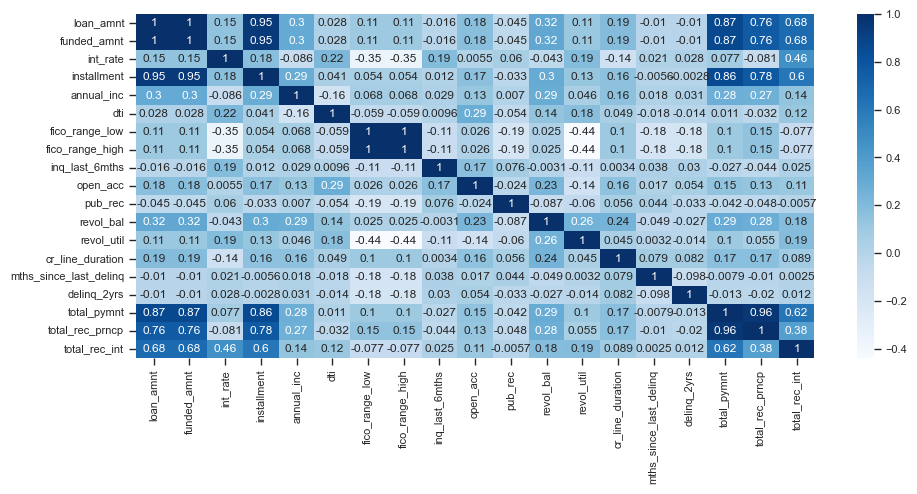

In [106]:
plt.figure(figsize = (10,5))

sns.set_context("paper", font_scale=0.9) 

sns.heatmap(x_train_norm[num_columns].corr(), 
        annot=True,
        cmap="Blues")

Loan amount and funded amount stringly correlates with annual income installment (0.95). Then, strong correlation is with total payment (0.87), total_rec_prncp (0.76), total_rec_int (0.68).

The rest correlations are weak.

<b>Test data:</b>

In [107]:
round(x_test[num_columns].describe(),1).T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,81131.0,14939.9,9023.9,1000.0,8000.0,13000.0,20000.0,40000.0
funded_amnt,81131.0,14939.8,9023.9,1000.0,8000.0,13000.0,20000.0,40000.0
int_rate,81131.0,13.0,4.9,5.3,9.5,12.0,15.6,31.0
installment,81131.0,449.7,272.0,30.1,252.1,380.4,602.1,1569.1
annual_inc,81131.0,81689.6,83591.5,1.0,50000.0,69395.0,96582.0,8400000.0
dti,81131.0,18.7,9.7,-1.0,12.3,18.1,24.7,999.0
fico_range_low,81131.0,695.3,31.1,660.0,670.0,690.0,710.0,845.0
fico_range_high,81131.0,699.3,31.1,664.0,674.0,694.0,714.0,850.0
inq_last_6mths,81131.0,0.6,0.9,0.0,0.0,0.0,1.0,5.0
open_acc,81131.0,12.0,5.8,1.0,8.0,11.0,15.0,86.0


In [108]:
x_test_norm_stg = x_test[cat_columns]

In [109]:
norm_data_test = preprocessing.normalize(x_test[num_columns], axis=0)
x_test_num = (pd.DataFrame(norm_data_test,columns=num_columns)).reset_index()
x_test_num = x_test_num.rename(columns={'index':'id'})

x_test_norm = pd.merge(x_test_norm_stg,x_test_num,how='left',on='id')
print(x_test_norm.shape)
x_test_norm.head(2)

(81131, 28)


,id,term,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int
0,0,36 months,manager,10+ years,MORTGAGE,Verified,home_improvement,MI,Individual,0.003218,0.003218,0.004601,0.003877,0.002703,0.007333,0.003582,0.003581,0.000000,0.004747,0.0,0.005730,0.005171,0.005649,0.000000,0.0,0.001657,0.001289,0.002703
1,1,36 months,real estate broker,10+ years,RENT,Not Verified,small_business,CO,Individual,0.004023,0.004023,0.003653,0.004598,0.001952,0.002470,0.003531,0.003531,0.003411,0.003429,0.0,0.000022,0.000056,0.002922,0.008188,0.0,0.004842,0.004944,0.003531


# Categorical values preparation

<b>Categorical variables distribution per adjustment approach</b>:

In [110]:
object_cols_ordinal = ['term', 'emp_length']

object_cols_category = ['home_ownership', 'verification_status', 
                        'purpose', 'addr_state', 'application_type']

object_cols_dummies = ['emp_title_mod']

## Ordinal encoder

For categorical variables where order, sequence is important to present, has a natural ordering to them:

In [111]:
ordinal_encoder = OrdinalEncoder()

x_train_norm[object_cols_ordinal] = ordinal_encoder.fit_transform(x_train_norm[object_cols_ordinal])
x_test_norm[object_cols_ordinal] = ordinal_encoder.transform(x_test_norm[object_cols_ordinal])

x_test_norm[object_cols_ordinal].head(3)

,term,emp_length
0,0.0,1.0
1,0.0,1.0
2,0.0,6.0


In [112]:
x_train_norm.shape

(324520, 28)

In [113]:
x_train_norm.head(2)

,id,term,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int
0,0,0.0,management officer,1.0,RENT,Not Verified,credit_card,CO,Individual,0.001507,0.001507,0.000670,0.001508,0.001720,0.001013,0.001841,0.001841,0.001707,0.002509,0.0,0.001010,0.001450,0.001954,0.004532,0.000000,0.001468,0.001637,0.000564
1,1,0.0,director,1.0,MORTGAGE,Source Verified,credit_card,NJ,Individual,0.002010,0.002010,0.000956,0.002080,0.001563,0.002142,0.001892,0.001891,0.000000,0.001321,0.0,0.000922,0.000595,0.002247,0.000423,0.001707,0.001835,0.001952,0.001054


In [114]:
x_train_norm

,id,term,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int
0,0,0.0,management officer,1.0,RENT,Not Verified,credit_card,CO,Individual,0.001507,0.001507,0.000670,0.001508,0.001720,0.001013,0.001841,0.001841,0.001707,0.002509,0.000000,0.001010,0.001450,0.001954,0.004532,0.000000,0.001468,0.001637,0.000564
1,1,0.0,director,1.0,MORTGAGE,Source Verified,credit_card,NJ,Individual,0.002010,0.002010,0.000956,0.002080,0.001563,0.002142,0.001892,0.001891,0.000000,0.001321,0.000000,0.000922,0.000595,0.002247,0.000423,0.001707,0.001835,0.001952,0.001054
2,2,0.0,manager,5.0,OWN,Source Verified,credit_card,IN,Individual,0.000703,0.000703,0.002140,0.000833,0.000391,0.002452,0.001677,0.001678,0.000000,0.001321,0.000000,0.000408,0.001527,0.000977,0.000000,0.000000,0.000304,0.000242,0.000471
3,3,0.0,manager,6.0,MORTGAGE,Not Verified,home_improvement,FL,Individual,0.002010,0.002010,0.001888,0.002315,0.001673,0.002510,0.001728,0.001728,0.006828,0.006339,0.000000,0.002928,0.001870,0.002052,0.002961,0.000000,0.002187,0.002479,0.000694
4,4,0.0,installer/technician,9.0,RENT,Source Verified,other,NE,Individual,0.000241,0.000241,0.001762,0.000274,0.000594,0.001425,0.001677,0.001678,0.001707,0.001057,0.000000,0.000262,0.001718,0.000684,0.000000,0.000000,0.000237,0.000226,0.000231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324515,324515,0.0,manager,1.0,MORTGAGE,Verified,debt_consolidation,CT,Individual,0.003015,0.003015,0.001384,0.003279,0.001016,0.001875,0.001791,0.001791,0.001707,0.000792,0.000000,0.000267,0.001630,0.001368,0.000604,0.005121,0.002761,0.002670,0.002540
324516,324516,0.0,manager,1.0,RENT,Not Verified,other,AZ,Individual,0.001206,0.001206,0.001006,0.001255,0.001563,0.000670,0.001803,0.001803,0.000000,0.000792,0.002442,0.000386,0.001690,0.002149,0.000000,0.000000,0.001351,0.001487,0.000589
324517,324517,0.0,project leader,2.0,RENT,Verified,car,CA,Individual,0.001507,0.001507,0.001445,0.001651,0.001329,0.001560,0.001665,0.001665,0.001707,0.002113,0.000000,0.001092,0.002768,0.001270,0.000000,0.000000,0.001757,0.001792,0.001293
324518,324518,0.0,vice president,1.0,MORTGAGE,Source Verified,home_improvement,CA,Individual,0.002010,0.002010,0.000994,0.002089,0.003908,0.000750,0.001765,0.001765,0.000000,0.001849,0.000000,0.000786,0.001284,0.002638,0.000060,0.005121,0.002288,0.002479,0.001146


In [115]:
x_test_norm.shape

(81131, 28)

In [116]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ord_en/x_train_ord_en.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ord_en/x_test_ord_en.csv'
x_train_export = x_train_norm.drop(columns=['id'])
x_train_export.to_csv(path_train,index=False)
x_test_export = x_test_norm.drop(columns=['id'])
x_test_export.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ord_en/y_train_ord_en.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ord_en/y_test_ord_en.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)

## One-Hot Encoding

For categorical values where order or sequence is absent

In [117]:
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

labels = list(x_train_norm.home_ownership.unique())
ohe = ColumnTransformer(
    transformers=[("ohe", OH_encoder, object_cols_category),],
    remainder="passthrough",
)
ohe.set_output(transform="pandas")

OH_cols_train = pd.DataFrame(ohe.fit_transform(x_train_norm[object_cols_category]))
OH_cols_test = pd.DataFrame(ohe.transform(x_test_norm[object_cols_category]))

# # Remove categorical columns (will replace with one-hot encoding)
num_x_train = x_train_norm.drop(object_cols_category, axis=1)
num_x_test = x_test_norm.drop(object_cols_category, axis=1)

# # Add one-hot encoded columns to numerical features
x_train = pd.concat([num_x_train, OH_cols_train], axis=1)
x_test = pd.concat([num_x_test, OH_cols_test], axis=1)

In [118]:
x_train.head(3)
x_train.shape

(324520, 95)

In [119]:
print(x_test.shape)
x_test.head(3)

(81131, 95)


,id,term,emp_title_mod,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_Not Verified,ohe__verification_status_Source Verified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__purpose_wedding,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_Joint App
0,0,0.0,manager,1.0,0.003218,0.003218,0.004601,0.003877,0.002703,0.007333,0.003582,0.003581,0.000000,0.004747,0.0,0.005730,0.005171,0.005649,0.000000,0.000000,0.001657,0.001289,0.002703,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.0,real estate broker,1.0,0.004023,0.004023,0.003653,0.004598,0.001952,0.002470,0.003531,0.003531,0.003411,0.003429,0.0,0.000022,0.000056,0.002922,0.008188,0.000000,0.004842,0.004944,0.003531,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0.0,executive assistant,6.0,0.004023,0.004023,0.002891,0.004404,0.001952,0.000753,0.003506,0.003506,0.000000,0.001319,0.0,0.001171,0.002240,0.003117,0.002408,0.006918,0.004788,0.004944,0.003289,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [120]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ohot_en/x_train_ohot_en.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ohot_en/x_test_ohot_en.csv'
x_train_export = x_train.drop(columns=['id'])
x_train_export.to_csv(path_train,index=False)
x_test_export = x_test.drop(columns=['id'])
x_test_export.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ohot_en/y_train_ohot_en.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ohot_en/y_test_ohot_en.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)

## Dummy variables

<b>For training dataset:</b>

In [121]:
x_train['IsManager'] = np.where(x_train.emp_title_mod == 'manager', 1,0)
x_train['EmploymentTitleNaN'] = np.where(x_train.emp_title_mod == 'nan', 1,0)
x_train['IsDirector'] = np.where(x_train.emp_title_mod == 'director', 1,0)
x_train['IsSales'] = np.where(x_train.emp_title_mod == 'sales', 1,0)
x_train['IsEngineer'] = np.where(x_train.emp_title_mod == 'engineer', 1,0)
x_train['IsTeacher'] = np.where(x_train.emp_title_mod == 'teacher', 1,0)
x_train['IsSupervisor'] = np.where(x_train.emp_title_mod == 'supervisor', 1,0)
x_train['IsAnalyst'] = np.where(x_train.emp_title_mod == 'analyst', 1,0)
x_train['IsDriver'] = np.where(x_train.emp_title_mod == 'driver', 1,0)
x_train['IsOwner'] = np.where(x_train.emp_title_mod == 'owner', 1,0)
x_train['IsNurse'] = np.where(x_train.emp_title_mod == 'nurse', 1,0)

x_train = x_train.drop(columns = ['emp_title_mod'])
x_train.head(2)

,id,term,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_Not Verified,ohe__verification_status_Source Verified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__purpose_wedding,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_Joint App,IsManager,EmploymentTitleNaN,IsDirector,IsSales,IsEngineer,IsTeacher,IsSupervisor,IsAnalyst,IsDriver,IsOwner,IsNurse
0,0,0.0,1.0,0.001507,0.001507,0.000670,0.001508,0.001720,0.001013,0.001841,0.001841,0.001707,0.002509,0.0,0.001010,0.001450,0.001954,0.004532,0.000000,0.001468,0.001637,0.000564,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.0,1.0,0.002010,0.002010,0.000956,0.002080,0.001563,0.002142,0.001892,0.001891,0.000000,0.001321,0.0,0.000922,0.000595,0.002247,0.000423,0.001707,0.001835,0.001952,0.001054,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0


<b>For test dataset:</b>

In [122]:
x_test['IsManager'] = np.where(x_test.emp_title_mod == 'manager', 1,0)
x_test['EmploymentTitleNaN'] = np.where(x_test.emp_title_mod == 'nan', 1,0)
x_test['IsDirector'] = np.where(x_test.emp_title_mod == 'director', 1,0)
x_test['IsSales'] = np.where(x_test.emp_title_mod == 'sales', 1,0)
x_test['IsEngineer'] = np.where(x_test.emp_title_mod == 'engineer', 1,0)
x_test['IsTeacher'] = np.where(x_test.emp_title_mod == 'teacher', 1,0)
x_test['IsSupervisor'] = np.where(x_test.emp_title_mod == 'supervisor', 1,0)
x_test['IsAnalyst'] = np.where(x_test.emp_title_mod == 'analyst', 1,0)
x_test['IsDriver'] = np.where(x_test.emp_title_mod == 'driver', 1,0)
x_test['IsOwner'] = np.where(x_test.emp_title_mod == 'owner', 1,0)
x_test['IsNurse'] = np.where(x_test.emp_title_mod == 'nurse', 1,0)

x_test = x_test.drop(columns = ['emp_title_mod'])
x_test.head(2)

,id,term,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_Not Verified,ohe__verification_status_Source Verified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__purpose_wedding,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_Joint App,IsManager,EmploymentTitleNaN,IsDirector,IsSales,IsEngineer,IsTeacher,IsSupervisor,IsAnalyst,IsDriver,IsOwner,IsNurse
0,0,0.0,1.0,0.003218,0.003218,0.004601,0.003877,0.002703,0.007333,0.003582,0.003581,0.000000,0.004747,0.0,0.005730,0.005171,0.005649,0.000000,0.0,0.001657,0.001289,0.002703,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.0,1.0,0.004023,0.004023,0.003653,0.004598,0.001952,0.002470,0.003531,0.003531,0.003411,0.003429,0.0,0.000022,0.000056,0.002922,0.008188,0.0,0.004842,0.004944,0.003531,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_dum_en/x_train_dum_en.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_dum_en/x_test_dum_en.csv'
x_train_export = x_train.drop(columns=['id'])
x_train_export.to_csv(path_train,index=False)
x_test_export = x_test.drop(columns=['id'])
x_test_export.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_dum_en/y_train_dum_en.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_dum_en/y_test_dum_en.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)

# Principal Component Analysis (PCA)

<b>Principal component analysis (PCA</b>) is a technique that transforms high-dimensions data into lower-dimensions while retaining as much information as possible.

PCA use cases in feature engineering:
- <b>Dimensionality reduction</b>: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- <b>Anomaly detection</b>: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- <b>Noise reduction</b>: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- <b>Decorrelation</b>: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

We will load the data which is prepared for the training:
- missing numeric values imputation
- numeric values normalisation
- categorical values ordinal encoding applied, which presents the order importance 

In [124]:
path_ = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ord_en/x_train_ord_en.csv'
x_train = pd.read_csv(path_)
print(list(x_train.columns))
x_train.head(4)

['term', 'emp_title_mod', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type', 'loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'cr_line_duration', 'mths_since_last_delinq', 'delinq_2yrs', 'total_pymnt', 'total_rec_prncp', 'total_rec_int']


,term,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,cr_line_duration,mths_since_last_delinq,delinq_2yrs,total_pymnt,total_rec_prncp,total_rec_int
0,0.0,management officer,1.0,RENT,Not Verified,credit_card,CO,Individual,0.001507,0.001507,0.000670,0.001508,0.001720,0.001013,0.001841,0.001841,0.001707,0.002509,0.0,0.001010,0.001450,0.001954,0.004532,0.000000,0.001468,0.001637,0.000564
1,0.0,director,1.0,MORTGAGE,Source Verified,credit_card,NJ,Individual,0.002010,0.002010,0.000956,0.002080,0.001563,0.002142,0.001892,0.001891,0.000000,0.001321,0.0,0.000922,0.000595,0.002247,0.000423,0.001707,0.001835,0.001952,0.001054
2,0.0,manager,5.0,OWN,Source Verified,credit_card,IN,Individual,0.000703,0.000703,0.002140,0.000833,0.000391,0.002452,0.001677,0.001678,0.000000,0.001321,0.0,0.000408,0.001527,0.000977,0.000000,0.000000,0.000304,0.000242,0.000471
3,0.0,manager,6.0,MORTGAGE,Not Verified,home_improvement,FL,Individual,0.002010,0.002010,0.001888,0.002315,0.001673,0.002510,0.001728,0.001728,0.006828,0.006339,0.0,0.002928,0.001870,0.002052,0.002961,0.000000,0.002187,0.002479,0.000694


In [125]:
cols = ['term', 'emp_length', 
        'loan_amnt', 'funded_amnt', 'int_rate', 
        'installment', 'annual_inc', 'dti', 'fico_range_low', 
        'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
        'delinq_2yrs','cr_line_duration','mths_since_last_delinq',
        'total_pymnt','total_rec_prncp','total_rec_int']

x_train_pca = x_train[cols]
print(x_train_pca.shape) 

X_scaled = StandardScaler().fit_transform(x_train_pca)

x_train_scaled = pd.DataFrame(X_scaled, columns=cols)
x_train_scaled.head(2)

(324520, 21)


,term,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,cr_line_duration,mths_since_last_delinq,total_pymnt,total_rec_prncp,total_rec_int
0,-0.595326,-0.782497,0.005353,0.005360,-1.563768,0.006843,0.370151,-0.741460,1.110562,1.110533,0.509405,1.216235,-0.370599,-0.005155,-0.18052,-0.381513,0.490110,2.487735,0.012332,0.213402,-0.537465
1,-0.595326,-0.782497,0.558997,0.559003,-1.103558,0.636364,0.240954,0.735221,1.750640,1.750599,-0.650908,-0.340339,-0.370599,-0.067081,-1.31418,0.659219,0.896175,-0.464406,0.386594,0.516351,-0.145186


In [126]:
path_ = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_grade/train_test_ord_en/y_train_ord_en.csv'
y_train = pd.read_csv(path_)
print(list(y_train.columns))
y_train.head(4)

['grade']


,grade
0,0.0
1,0.0
2,3.0
3,2.0


In [127]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(x_train_scaled)

# # Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,0.013082,2.009523,1.223098,0.736986,1.161127,-1.564108,-0.685890,-0.396718,-1.743475,0.034902,0.169607,-0.144887,-0.300533,0.690306,-1.103143,-0.058460,0.069253,-0.028056,-0.004505,0.000013,-0.000021
1,1.038463,3.040273,0.044990,0.449186,-0.210738,0.323838,0.582576,-1.291159,0.087697,-0.331525,-0.149039,0.964146,-0.050791,-0.196724,0.359998,0.564785,-0.014809,-0.013682,-0.022041,-0.000002,-0.000029
2,-2.477662,-1.372355,-0.635914,0.051310,-1.131862,0.654675,-0.763907,-0.096622,0.395774,0.040547,0.440570,0.194642,0.430589,-0.736746,0.588084,0.398230,-0.252566,0.100331,-0.040103,-0.000026,0.000016
3,2.264242,-0.803733,0.894895,5.319555,2.864889,0.980152,-3.383316,0.977496,-1.147117,0.814375,0.027543,-1.459524,0.558033,0.741610,-1.624019,-1.061929,-0.475416,-0.018367,-0.025507,0.000023,0.000006
4,-3.407721,-1.162380,-0.320066,-0.750004,-0.438655,1.111616,-0.952644,1.424625,0.148725,0.107444,-0.339740,-0.328746,0.251325,-0.047447,0.360973,0.085081,0.175164,0.082298,-0.002290,-0.000023,0.000016


We'll wrap the loadings up in a dataframe.

In [128]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=x_train_scaled.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
term,0.155480,-0.131885,-0.469971,0.065442,-0.015674,-0.244734,0.369717,0.194962,-0.059336,-0.170833,0.088045,-0.253395,-0.075845,0.431029,0.280079,-0.128166,-0.209403,-0.251898,-0.007717,2.104494e-05,4.302368e-06
emp_length,-0.021475,-0.001849,-0.073866,-0.125798,-0.027975,0.265650,-0.406082,0.601629,0.062029,-0.580333,-0.194989,-0.002230,0.034658,-0.010072,0.008240,-0.002117,0.002449,-0.000302,0.000107,5.763431e-07,1.034712e-06
loan_amnt,0.414514,0.007443,-0.032788,-0.072044,0.024376,0.012798,-0.008969,-0.030700,-0.006431,-0.023166,0.005871,-0.034406,-0.007385,0.047412,-0.041821,0.281058,-0.261042,0.408687,-0.011515,7.070604e-01,-1.096451e-05
funded_amnt,0.414515,0.007445,-0.032786,-0.072043,0.024382,0.012798,-0.008970,-0.030701,-0.006433,-0.023169,0.005872,-0.034404,-0.007386,0.047401,-0.041828,0.281050,-0.261037,0.408536,-0.011468,-7.071532e-01,3.322655e-06
int_rate,0.077874,-0.382727,-0.416273,0.029122,0.049078,0.002807,0.041421,0.060908,-0.005768,0.107114,-0.059172,0.254700,0.034793,-0.560367,-0.106843,-0.427991,-0.246897,0.121672,-0.005105,-7.669807e-06,-5.505125e-06
installment,0.397271,-0.006081,0.057292,-0.095591,0.041495,0.095583,-0.128835,-0.093094,0.012442,0.046112,-0.030277,0.084543,0.026747,-0.176087,-0.153452,0.265744,-0.261622,-0.766073,-0.045247,8.070829e-05,8.604348e-06
annual_inc,0.157520,0.074185,0.295839,0.060029,0.139907,-0.069395,0.258470,0.518741,-0.077731,0.149452,0.363014,0.491522,0.311534,0.038304,0.128628,-0.005555,0.037629,-0.002711,0.000272,3.976552e-07,1.043584e-06
dti,0.030919,-0.133725,-0.174339,0.499202,-0.288149,0.031347,-0.324114,-0.259869,0.151376,-0.097855,0.039113,0.495780,0.022277,0.195455,0.324940,0.142874,0.021308,-0.001011,-0.000806,-4.406208e-06,3.471775e-06
fico_range_low,0.045318,0.547093,-0.235389,0.067929,-0.056885,-0.066217,0.038553,0.026998,0.025505,0.006023,-0.085854,0.188174,-0.105612,0.036370,-0.246261,-0.109777,-0.011653,0.000049,0.000524,-5.249676e-06,-7.071081e-01
fico_range_high,0.045318,0.547092,-0.235388,0.067927,-0.056883,-0.066218,0.038557,0.026996,0.025505,0.006022,-0.085858,0.188175,-0.105611,0.036366,-0.246267,-0.109782,-0.011655,0.000065,0.000539,9.036373e-06,7.071055e-01


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured.

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

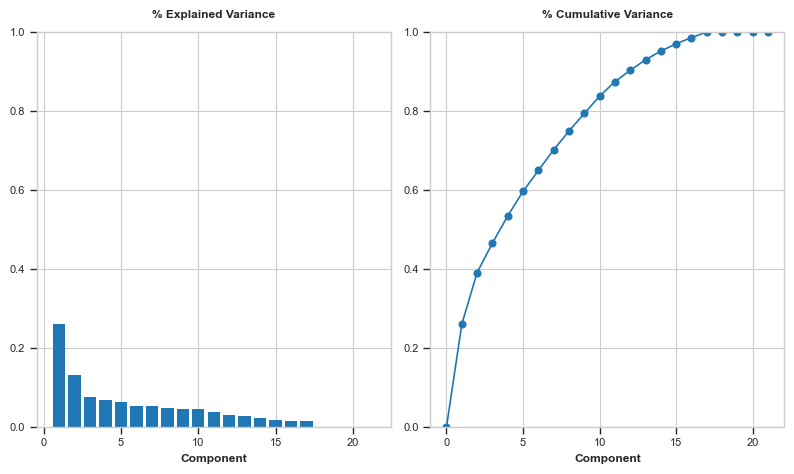

In [129]:
# Look at explained variance
plot_variance(pca)

The chart informs us that using 13 principal components instead of 21 is fine because they can capture 90%+ of the variance.

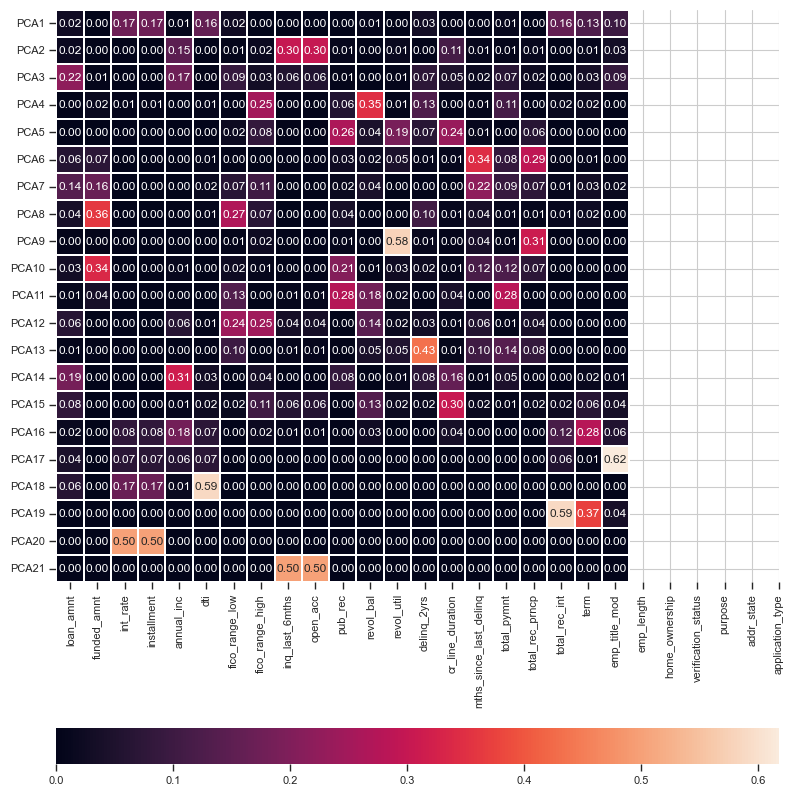

In [130]:
plt.figure(figsize=(8,10))

# Feature Weight
_ = sns.heatmap(pca.components_**2,
                 yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(features),
                 annot=True,
                 fmt='.2f',
                 square=True,
                 linewidths=0.05,
                 cbar_kws={"orientation": "horizontal"})

We can see that PCA1 is made from 17% of interest rate and installment, 16% of dti and total_rec_int, and 13% of term. 

PCA2 is most made from inq_last_6_month and open_acc (30%).

PCA20 is made from int_rate and installment (50%).

Let's also look at the MI scores of the components.

In [131]:
mi_scores = make_mi_scores(X_pca, y_train, discrete_features=False)
mi_scores

PC18    0.335189
PC2     0.328767
PC3     0.164193
PC17    0.141705
PC16    0.121642
PC19    0.112386
PC14    0.094743
PC20    0.070213
PC21    0.061436
PC12    0.030882
PC1     0.024644
PC15    0.012585
PC10    0.009512
PC5     0.009291
PC9     0.006874
PC7     0.006049
PC6     0.003528
PC8     0.003258
PC13    0.003066
PC11    0.002580
PC4     0.001142
Name: MI Scores, dtype: float64